# Filter cells based on QC criteria

In this notebook, we'll retrieve the metadata from .h5 and .arrow files, combine these for each cell, then filter based on the following QC criteria:



## Load packages

hise: The Human Immune System Explorer R SDK package  
dplyr: Dataframe handling functions  
ggplot2: Plotting library

In [1]:
library(hise)
library(dplyr)
library(ggplot2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
sample_manifest <- read.csv("../common/EXP00454_TEAseq_sample_manifest.csv")

## Retrieve files from HISE

The metadata from RNA/ADT .h5 files and from ATAC .arrow files was previously assembled across all samples. We'll use the file UUIDs from these previous steps to retrieve both files, which will be stored in `cache/`.

In [3]:
rna_adt_uuid <- "28b8a1e9-26ff-4b44-8ac9-389f1f9eb445"
atac_uuid <- "d6fc10e1-2283-4086-ac08-ee7a04256bef"

In [4]:
res <- hise::cacheFiles(list(rna_adt_uuid))
res <- hise::cacheFiles(list(atac_uuid))

submitting request as query ID first...

retrieving files using fileIDS...

submitting request as query ID first...

retrieving files using fileIDS...



In [5]:
rna_meta <- read.csv("cache/28b8a1e9-26ff-4b44-8ac9-389f1f9eb445/vrd_rna_adt_cell_metadata.csv")

In [6]:
nrow(rna_meta)

[1] 181518

In [7]:
atac_meta <- read.csv("cache/d6fc10e1-2283-4086-ac08-ee7a04256bef/vrd_atac_cell_metadata.csv")

In [8]:
nrow(atac_meta)

[1] 168062

## Filter RNA/ADT metadata

We'll use the following criteria to filter cell based on scRNA-seq and ADT quality control metrics:

**scRNA-seq**  

In [9]:
min_genes <- 500  
max_genes <- 4e3  

max_frac_mito_umis <- 0.2

**ADT**  

In [10]:
min_adt_umis <- 1e3  
max_adt_umis <- 1e4

Prior to filtering, let's make a summary table and a few plots to see what we'll exclude with these criteria.

In [11]:
rna_meta <- rna_meta %>%
  left_join(sample_manifest) %>%
  mutate(frac_mito_umis = n_mito_umis / n_umis)

Joining with `by = join_by(pbmc_sample_id)`


In [12]:
qc_filter_summary <- rna_meta %>%
  reframe(
      criteria = c(paste("n_genes >", min_genes), 
                   paste("n_genes <", max_genes),
                   paste("frac_mito_umis <", max_frac_mito_umis),
                   paste("adt_umis >", min_adt_umis),
                   paste("adt_umis <", max_adt_umis),
                   "all"),
      n_pass = c(sum(n_genes > min_genes), 
                 sum(n_genes < max_genes),
                 sum(frac_mito_umis < max_frac_mito_umis),
                 sum(adt_umis > min_adt_umis),
                 sum(adt_umis < max_adt_umis),
                 sum(n_genes > min_genes & 
                     n_genes < max_genes & 
                     frac_mito_umis < max_frac_mito_umis & 
                     adt_umis > min_adt_umis & 
                     adt_umis < max_adt_umis)),
      n_fail = c(sum(n_genes <= min_genes), 
                 sum(n_genes >= max_genes),
                 sum(frac_mito_umis >= max_frac_mito_umis),
                 sum(adt_umis <= min_adt_umis),
                 sum(adt_umis >= max_adt_umis),
                 sum(!(n_genes > min_genes & 
                     n_genes < max_genes & 
                     frac_mito_umis < max_frac_mito_umis & 
                     adt_umis > min_adt_umis & 
                     adt_umis < max_adt_umis))),
      perc_fail = round(n_fail / n() * 100, 2)
  )

In [13]:
qc_filter_summary

criteria,n_pass,n_fail,perc_fail
<chr>,<int>,<int>,<dbl>
n_genes > 500,176349,5169,2.85
n_genes < 4000,181482,36,0.02
frac_mito_umis < 0.2,174285,7233,3.98
adt_umis > 1000,178467,3051,1.68
adt_umis < 10000,180900,618,0.34
all,170634,10884,6.00


### N Genes per sample

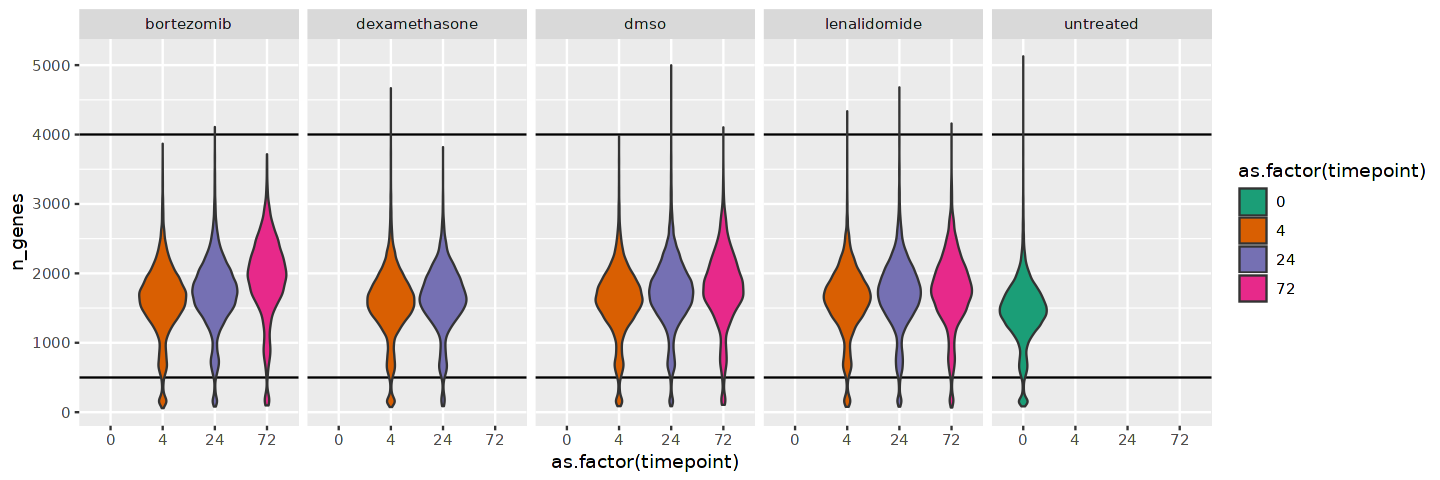

In [14]:
options(repr.plot.width = 12, repr.plot.height = 4)

limit_df <- data.frame(cutoffs = c(min_genes, max_genes))

ggplot() +
  geom_hline(
      data = limit_df,
      aes(yintercept = cutoffs)
  ) +
  geom_violin(
      data = rna_meta,
      aes(x = as.factor(timepoint),
          y = n_genes,
          fill = as.factor(timepoint))
  ) +
  scale_fill_brewer(type = "qual", palette = 2) +
  facet_wrap(~ treatment, ncol = 5)

### Fraction Mitochondrial UMIs per sample

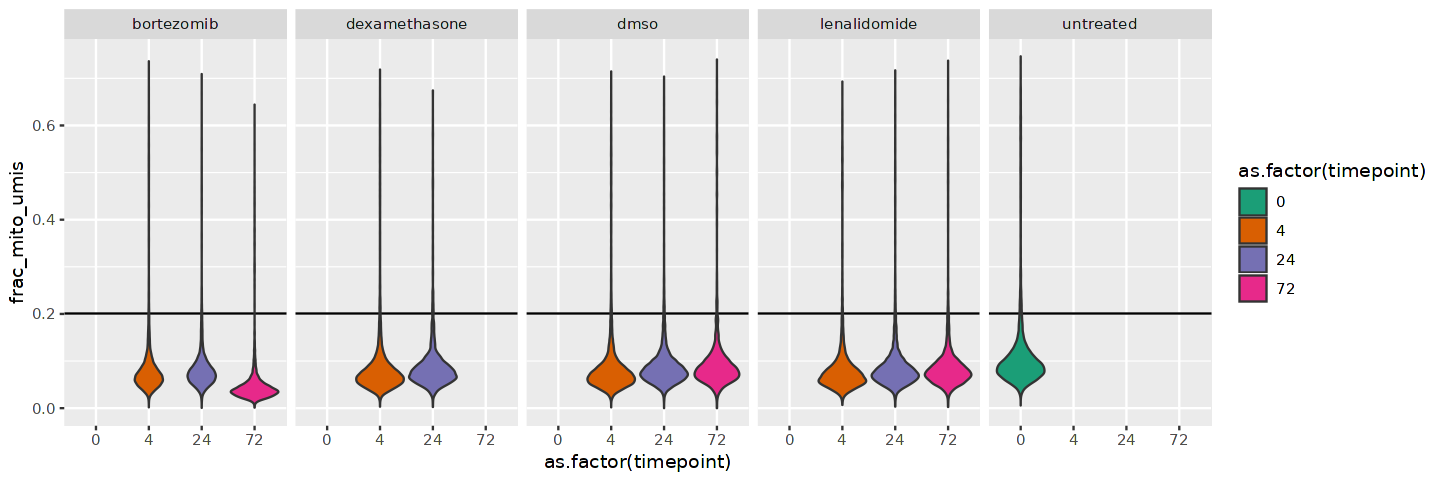

In [15]:
options(repr.plot.width = 12, repr.plot.height = 4)

limit_df <- data.frame(cutoffs = c(max_frac_mito_umis))

ggplot() +
  geom_hline(
      data = limit_df,
      aes(yintercept = cutoffs)
  ) +
  geom_violin(
      data = rna_meta,
      aes(x = as.factor(timepoint),
          y = frac_mito_umis,
          fill = as.factor(timepoint))
  ) +
  scale_fill_brewer(type = "qual", palette = 2) +
  facet_wrap(~ treatment, ncol = 5)

### ADT UMIs per sample

Warning message:
“Removed 155 rows containing non-finite values (`stat_ydensity()`).”


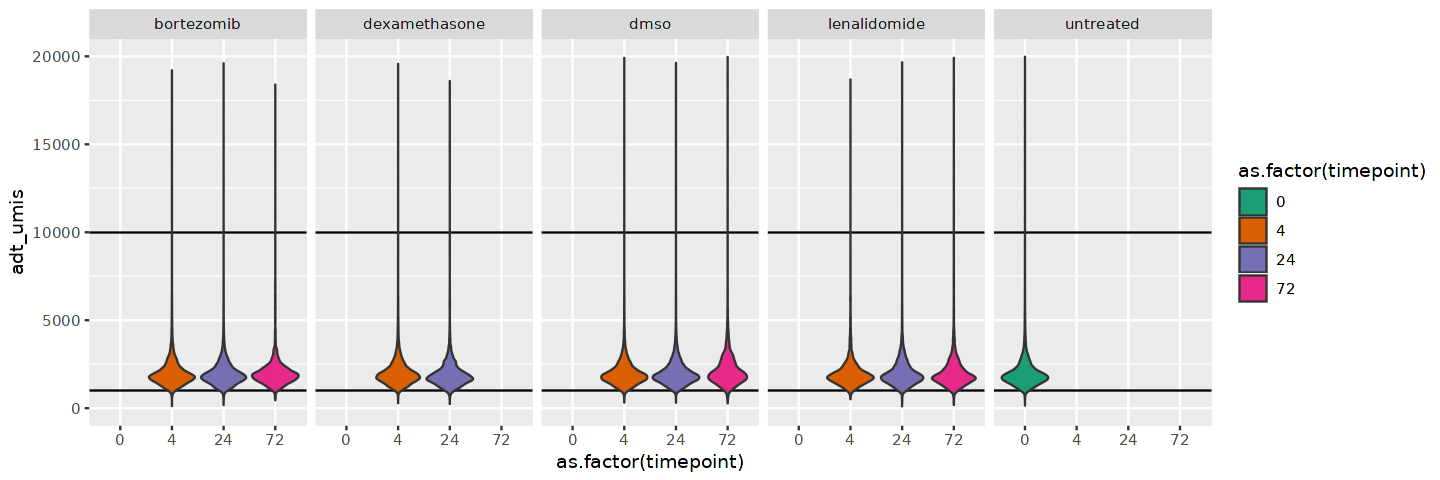

In [16]:
options(repr.plot.width = 12, repr.plot.height = 4)

limit_df <- data.frame(cutoffs = c(min_adt_umis, max_adt_umis))

ggplot() +
  geom_hline(
      data = limit_df,
      aes(yintercept = cutoffs)
  ) +
  geom_violin(
      data = rna_meta,
      aes(x = as.factor(timepoint),
          y = adt_umis,
          fill = as.factor(timepoint))
  ) +
  scale_y_continuous(limits = c(1, 2e4)) +
  scale_fill_brewer(type = "qual", palette = 2) +
  facet_wrap(~ treatment, ncol = 5)

### Filter RNA criteria

Now, we'll filter to remove cells that fail these metrics

In [17]:
filtered_rna_meta <- rna_meta %>%
  filter(
      n_genes > min_genes,
      n_genes < max_genes,
      frac_mito_umis < max_frac_mito_umis,
      adt_umis > min_adt_umis,
      adt_umis < max_adt_umis
  )
nrow(filtered_rna_meta)

[1] 170634

In [18]:
filtered_rna_meta %>%
  group_by(treatment, timepoint) %>%
  summarise(n_cells = n())

`summarise()` has grouped output by 'treatment'. You can override using the
`.groups` argument.


treatment,timepoint,n_cells
<chr>,<int>,<int>
bortezomib,4,17169
bortezomib,24,19797
bortezomib,72,5340
dexamethasone,4,32210
dexamethasone,24,4881
dmso,4,12627
dmso,24,25672
dmso,72,3266
lenalidomide,4,6666


**Note:** We see that the number of cells across samples is uneven. This is due to a cell counting error at the lab bench. This is unfortunate for analyses that span many samples, but we should still have adequate power to analyze many T cell types.

## Filter ATAC metadata

Our scATAC-seq pipeline does a good job of pre-filtering the ATAC-seq data. A minimum threshhold of 1,000 unique fragments has already been applied at this stage, so we just need to filter on the high end to remove some possible doublets and cells with abnormally high mitochondrial reads. Note that mitochondrial fragments are computed prior to deduplication of reads, so we use n_fragments as the denominator.

We'll use the following criteria to filter cell based on scATAC-seq quality control metrics:

In [19]:
min_frags <- 1e3
max_frags <- 2e4

max_frac_mito <- 0.1

In [20]:
atac_meta <- atac_meta %>%
  mutate(pbmc_sample_id = sub(".+_","",Sample)) %>%
  left_join(sample_manifest) %>%
  mutate(frac_mito = n_mito / n_fragments)

Joining with `by = join_by(pbmc_sample_id)`


In [21]:
atac_meta %>%
  reframe(
      criteria = c(paste("n_unique >", min_frags), 
                   paste("n_unique <", max_frags),
                   paste("frac_mito_frags <", max_frac_mito),
                   "all"),
      n_pass = c(sum(n_unique > min_frags), 
                 sum(n_unique < max_frags),
                 sum(frac_mito < max_frac_mito),
                 sum(n_unique > min_frags & 
                     n_unique < max_frags & 
                     frac_mito < max_frac_mito)),
      n_fail = c(sum(n_unique <= min_frags), 
                 sum(n_unique >= max_frags),
                 sum(frac_mito >= max_frac_mito),
                 sum(!(n_unique > min_frags & 
                     n_unique < max_frags & 
                     frac_mito < max_frac_mito))),
      perc_fail = round(n_fail / n() * 100, 2)
  )

criteria,n_pass,n_fail,perc_fail
<chr>,<int>,<int>,<dbl>
n_unique > 1000,168062,0,0.00
n_unique < 20000,166771,1291,0.77
frac_mito_frags < 0.1,167991,71,0.04
all,166700,1362,0.81


### Unique fragments

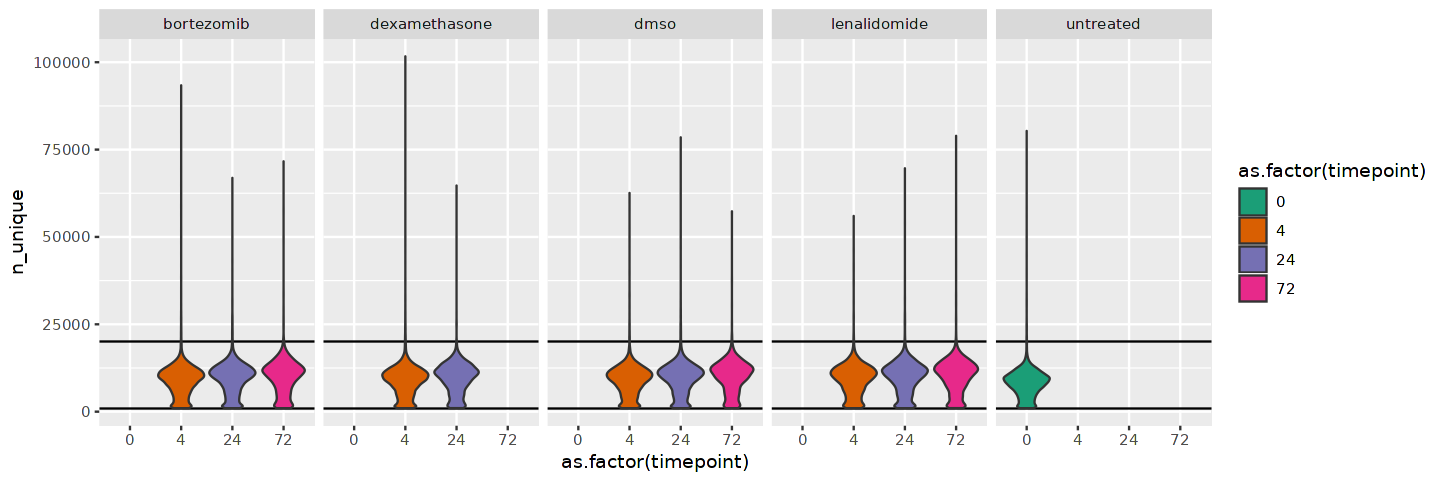

In [22]:
options(repr.plot.width = 12, repr.plot.height = 4)

limit_df <- data.frame(cutoffs = c(min_frags, max_frags))

ggplot() +
  geom_hline(
      data = limit_df,
      aes(yintercept = cutoffs)
  ) +
  geom_violin(
      data = atac_meta,
      aes(x = as.factor(timepoint),
          y = n_unique,
          fill = as.factor(timepoint))
  ) +
  scale_fill_brewer(type = "qual", palette = 2) +
  facet_wrap(~ treatment, ncol = 5)

### Mitochondrial fragments

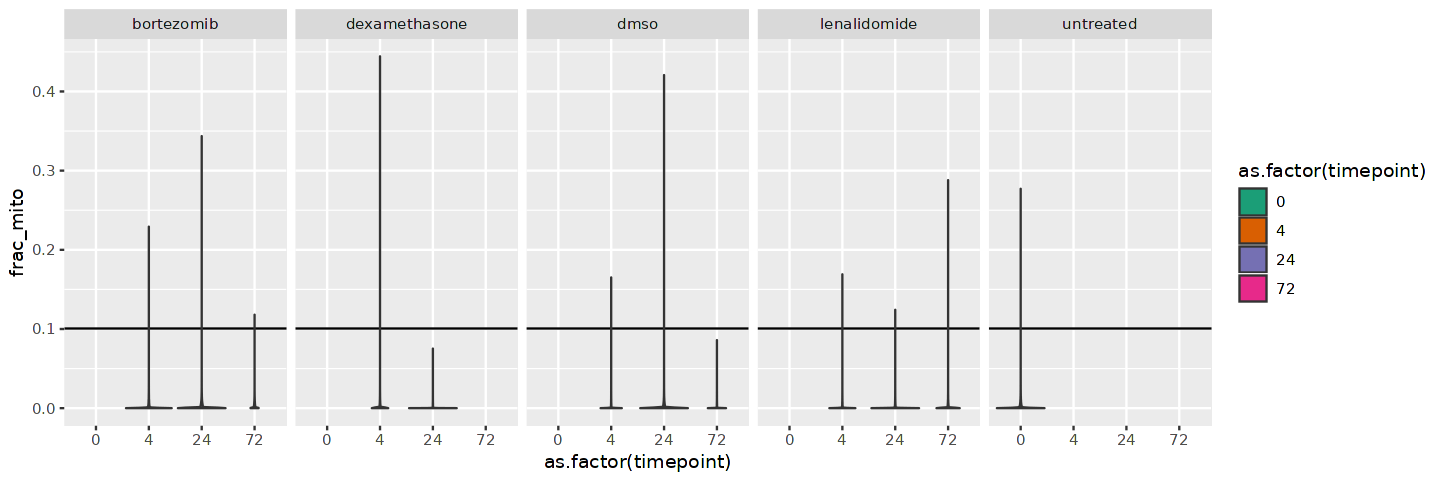

In [23]:
options(repr.plot.width = 12, repr.plot.height = 4)

limit_df <- data.frame(cutoffs = c(max_frac_mito))

ggplot() +
  geom_hline(
      data = limit_df,
      aes(yintercept = cutoffs)
  ) +
  geom_violin(
      data = atac_meta,
      aes(x = as.factor(timepoint),
          y = frac_mito,
          fill = as.factor(timepoint))
  ) +
  scale_fill_brewer(type = "qual", palette = 2) +
  facet_wrap(~ treatment, ncol = 5)

### Filter ATAC criteria

Now, we'll filter to remove cells that fail these metrics

In [24]:
filtered_atac_meta <- atac_meta %>%
  filter(
      n_unique > min_frags,
      n_unique < max_frags,
      frac_mito < max_frac_mito
  )
nrow(filtered_atac_meta)

[1] 166700

In [25]:
filtered_atac_meta %>%
  group_by(treatment, timepoint) %>%
  summarise(n_cells = n())

`summarise()` has grouped output by 'treatment'. You can override using the
`.groups` argument.


treatment,timepoint,n_cells
<chr>,<int>,<int>
bortezomib,4,16801
bortezomib,24,19161
bortezomib,72,5130
dexamethasone,4,31393
dexamethasone,24,4787
dmso,4,12387
dmso,24,24802
dmso,72,3187
lenalidomide,4,6551


## Combine filters across barcodes

Finally, we'll take the filtered metadata across both sets of barcodes and generate a clean, unified set to carry forward for analysis.

In [26]:
final_rna_meta <- filtered_rna_meta %>%
  filter(barcodes %in% filtered_atac_meta$barcodes) %>%
  select(barcodes, adt_umis, batch_id, pool_id, chip_id, well_id, 
         pbmc_sample_id, treatment, timepoint,
         n_reads, n_umis, n_genes, 
         n_mito_umis, frac_mito_umis,
         original_barcodes, hto_barcode, hto_category)

In [27]:
nrow(final_rna_meta)

[1] 158276

In [28]:
names(filtered_atac_meta)

[1] "Sample"            "well_id"           "TSSEnrichment"    
 [4] "tss_frac"          "tss_count"         "singlet"          
 [7] "ReadsInTSS"        "ReadsInPromoter"   "ReadsInBlacklist" 
[10] "PromoterRatio"     "pool_id"           "peaks_frac"       
[13] "peaks_count"       "pbmc_sample_id"    "PassQC"           
[16] "original_barcodes" "NucleosomeRatio"   "nMultiFrags"      
[19] "nMonoFrags"        "nFrags"            "nDiFrags"         
[22] "n_unique"          "n_mito"            "n_fragments"      
[25] "n_duplicate"       "gene_bodies_frac"  "gene_bodies_count"
[28] "DoubletScore"      "DoubletEnrichment" "chip_id"          
[31] "cell_name"         "BlacklistRatio"    "batch_id"         
[34] "barcodes"          "altius_frac"       "altius_count"     
[37] "archr_name"        "lab_label"         "stimulation"      
[40] "treatment"         "timepoint"         "treat_time"       
[43] "frac_mito"

In [29]:
final_atac_meta <- filtered_atac_meta %>%
  filter(barcodes %in% filtered_rna_meta$barcodes) %>%
  select(barcodes, Sample, archr_name,
         n_fragments, n_unique, n_mito, frac_mito)

In [30]:
final_meta <- final_rna_meta %>%
  left_join(final_atac_meta)

Joining with `by = join_by(barcodes)`


## Write output file

Write the metadata as a .csv for later use. We remove `row.names` and set `quote = FALSE` to simplify the outputs and increase compatibility with other tools.

In [31]:
dir.create("output")

Warning message in dir.create("output"):
“'output' already exists”


In [37]:
write.csv(
    final_meta,
    "output/filtered_tea_cell_metadata.csv",
    row.names = FALSE,
    quote = FALSE
)

## Store results in HISE

Finally, we store the output file in our Collaboration Space for later retrieval and use. We need to provide the UUID for our Collaboration Space (aka `studySpaceId`), as well as a title for this step in our analysis process.

The hise function `uploadFiles()` also requires the FileIDs from the original fileset for reference, which we assembled above when files were retrieved (`input_file_uuids`)

In [38]:
study_space_uuid <- "40df6403-29f0-4b45-ab7d-f46d420c422e"
title <- "VRd TEA-seq QC filtered cell metadata"

In [39]:
out_files <- list.files(
    "output",
    full.names = TRUE
)
out_list <- as.list(out_files)

In [41]:
uploadFiles(
    files = out_list,
    studySpaceId = study_space_uuid,
    title = title,
    inputFileIds = list(rna_adt_uuid, atac_uuid),
    store = "project",
    doPrompt = FALSE
)

$files
$files[[1]]
[1] "output/filtered_tea_cell_metadata.csv"


$traceId
[1] "93c5988b-8aa4-4ac7-b28a-6c4e39f0c35f"

In [42]:
sessionInfo()

R version 4.2.2 Patched (2022-11-10 r83330)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/liblapack.so.3

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] ggplot2_3.4.2 dplyr_1.1.0   hise_2.16.0  

loaded via a namespace (and not attached):
 [1] RColorBrewer_1.1-3 pillar_1.9.0       compiler_4.2.2     bitops_1.0-7      
 [5] base64enc_0.1-3    tools_4.2.2        digest_0.6.33      uuid_1.1-0        
 [9] jsonlite_1.8.7     evaluate_0.21      li